# Amazon Basics High-Speed HDMI Cable - 6.5 Feet 

In [1]:
#!pip install spacy==2.2

In [2]:
# Load dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import spacy
import en_core_web_sm
import sys
import unicodedata
import os

import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
np.random.seed(7) # seeding random number generator

In [3]:
# File paths
raw_data_file = os.path.join("","Resources","data","amazon_reviews.tsv")
cleaned_data_file = os.path.join("","Resources","data","amazon_reviews.csv")

In [4]:
# Load Amzon review raw file 
dfs = pd.read_csv(raw_data_file, sep='\t', chunksize=50,error_bad_lines=False,warn_bad_lines=False)
# build the clean file
for df in dfs:
    df.to_csv(cleaned_data_file, sep=',', mode='a')

In [5]:
# Load error free Amazon review file
df = pd.read_csv(cleaned_data_file)

In [6]:
# Remove duplicate header entries
df = df[df['review_id']!='review_id']

In [7]:
# Display sample results
df.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0.0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,1.0,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,2.0,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,3.0,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,4.0,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [8]:
# Get product review count
df['product_id'].value_counts()

B003L1ZYYM    15334
B0002L5R78    11166
B003EM8008     9766
B0012S4APK     9359
B0001FTVEK     8793
              ...  
B00ERVWVNM        1
B002AEVPWG        1
B0055MQUZW        1
B00RRGGX2Y        1
B0015CRF2I        1
Name: product_id, Length: 185775, dtype: int64

In [9]:
# We will be anlyzing product B003L1ZYYM

In [10]:
#Lets get data specific to product ID=B003L1ZYYM   
df_review = df[df['product_id']=='B003L1ZYYM']

In [11]:
# Check data dimension - this step is required to make sure we have enough data points to train and test model
df_review.shape

(15334, 16)

In [12]:
# Select meaningful reviews by filtering reviews with more than 40 words in the review comment.
df_review = df_review[df_review['review_body'].fillna("").apply(lambda x: len(x.split())>=25)] 

In [13]:
# Check the data dimension
df_review.shape

(5296, 16)

In [14]:
# Lemmatization and Stop words
nlp = en_core_web_sm.load()

# Define default stopwords list
stoplist = spacy.lang.en.STOP_WORDS 

# Functions to remove encodes
def replace_ptbr_char_by_word(word):
    #  """ Will remove the encode token by token"""
    word = str(word)
    word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def remove_pt_br_char_by_text(text):
    #  """ Will remove the encode using the entire text"""
    text = str(text)
    text = " ".join(replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist)
    return text

In [15]:
# Lemmatization and Stop words
df_review['review_body'] = df_review['review_body'].apply(remove_pt_br_char_by_text)

In [16]:
# Keep only required columns
df_review=df_review[['review_body','star_rating']]

In [17]:
# Check data types
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5296 entries, 1982 to 2734959
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  5296 non-null   object
 1   star_rating  5296 non-null   object
dtypes: object(2)
memory usage: 124.1+ KB


In [18]:
# Convert review_body to text
df_review['review_body'] = df_review['review_body'].astype(str)

In [19]:
# Convert star_rating to text
df_review['star_rating'] = df_review['star_rating'].astype(int)

In [20]:
# Change categories to buckets
cat = ['low','neutral','high']
def cat_y(y):
    y=int(y)
    if y<=2:
        return cat[0]
    elif y>=4:
        return cat[2]
    else:
        return cat[1]


In [21]:
# Populat new column
df_review['bucket'] = df_review['star_rating'].fillna(0).apply(cat_y)

In [22]:
# Display df sample
df_review.head()

,review_body,star_rating,bucket
1982,Bought replacement HDMI cable. The Local elect...,5,high
2033,Just good HDMI cable there! It's basic HDMI ca...,5,high
2239,"Great Cables, Anything 25 feet works fine tran...",5,high
3013,It works great fast! good price too! looking c...,5,high
3247,"cheaper work apple tv, tivo roku connected sam...",5,high


In [23]:
# Keep only required columns
df_review=df_review[['review_body','bucket']]

In [24]:
# Display sample data
df_review.head() 

,review_body,bucket
1982,Bought replacement HDMI cable. The Local elect...,high
2033,Just good HDMI cable there! It's basic HDMI ca...,high
2239,"Great Cables, Anything 25 feet works fine tran...",high
3013,It works great fast! good price too! looking c...,high
3247,"cheaper work apple tv, tivo roku connected sam...",high


### Calculate Term Frequencies
- Calculate both the actual term frequency as well as the tfidf weighted term frequency. Let's limit words occuring in at most 90% of documents and in at least 10 documents. 
- The term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" or "irrelvant" words that occur in many reviews.

- Perform two tokenizing operations. First, tokenize only letters, ignoring special symbols & numbers. 
- Use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

In [25]:
# Calculate TD and IDF
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(df_review['review_body'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(df_review['review_body'], use_idf=True, max_df=0.90, min_df=10)

### Compute topics using Kmeans and LDA

- Kmeans approach: Using our TFIDF matrix, cluster documents into N clusters based on their TFIDF similarity. Within each cluster, count the top occuring terms.

- LDA approach: Using TF matrix, attempt to extact N topics from the collection of documents.

##### Note: Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. 

In [26]:
# Let's choose 20 topics
n_topics = 20

# LDA Approach
def get_lda(data, topics):
    m = LatentDirichletAllocation(n_components=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

# Kmeans Approach
def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

### Show cluster top 15 words per topic
- First extract the top 15 stemmed words per topic in our LDA model. 
- Repeate process for kmeans clustered documents. 

##### Note: Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [27]:
# Show topics
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
# Show Clusters    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()

In [28]:
# LDA topic 
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 20)

Top 15 stemmed words per topic in LDA model

Topic #0:
use, connect, tv, monitor, work, laptop, comput, problem, p, cabl, pc, sturdi, simpli, perfect, good, solid, inch, lcd, great, internet
Topic #1:
roku, i'v, month, x, they'r, wait, servic, sinc, continu, spent, custom, realiz, regular, previous, product, major, feel, i'll, proper, twice
Topic #2:
br, cabl, hdmi, support, audio, high, standard, video, ethernet, speed, perform, d, gold, amazonbas, qualiti, plate, construct, p, latest, connector
Topic #3:
cabl, hdmi, need, like, work, purchas, price, reason, length, thing, box, qualiti, amazon, great, end, littl, devic, perfect, pay, fit
Topic #4:
cabl, buy, hdmi, money, work, don't, pay, best, amazon, price, monster, expens, save, better, store, want, fast, spend, cheap, great
Topic #5:
cabl, issu, work, day, i'm, doesn't, far, haven't, amazon, problem, xbox, deal, prime, i'v, good, like, use, look, hdmi, i'd
Topic #6:
packag, box, come, second, plastic, open, room, easi, plus, live,

In [29]:
# Kmean cluster of words
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(),20)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
cabl, spend, digit, signal, don't, hdmi, money, work, need, expens, good, lot, better, qualiti, reason, price, buy, peopl, differ, fine
Cluster #1:
buy, cabl, best, hdmi, expens, work, money, amazon, price, need, qualiti, great, don't, save, cheap, bought, good, like, monster, differ
Cluster #2:
br, cabl, hdmi, work, qualiti, price, need, amazon, tv, great, buy, good, connect, product, bought, don't, like, problem, use, perfect
Cluster #3:
beat, can't, price, cabl, hdmi, qualiti, work, amazon, great, need, differ, buy, good, time, product, money, high, issu, tell, perfect
Cluster #4:
great, cabl, price, work, hdmi, qualiti, need, good, pictur, purchas, buy, product, look, bought, sound, time, tv, recommend, cheap, pay
Cluster #5:
laptop, tv, connect, work, use, cabl, great, watch, movi, screen, hdmi, hook, qualiti, good, sound, problem, pictur, need, price, plug
Cluster #6:
length, perfect, cabl, need, right, hdmi, work, pri

## Prepare data for plotting
- TF/TFIDF matricies is a challenge to graphically represent documents as charts are limited to 3 dimensions. 
- Perform a heirarchical clustering, but the number of documents makes this approach very slow. 
- Let's perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

In [30]:

def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 30)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

### Plot Data
- Use LDA and Kmeans labels with reduced dimensions to plot our documents. 
- Create a rainbow color scheme which allows for a variable number of topics/clusters. 
- The plot tends to overlap quite a bit.  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

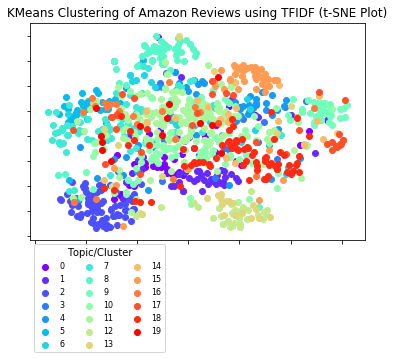

In [31]:
# Cluster topc plot
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

# Plot
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

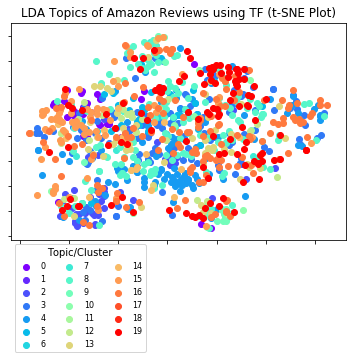

In [32]:
# LDA topics plot
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

### Prepare data for prediction
- Scatter plots helps to understand how the data is structured, but it doesn't tell what drives positive or negative reviews. - - Lets use words within reviews to build a predictive scoring model.
- When training models, split the data 70%/30% where 30% will be used for prediction to gauge final accuracy of the model.
- For each review, the model that scores the highest will tell us which kind of review it likely is.

In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, df_review['bucket'], test_size=0.3)

### Calculate model accuracies
- Three different approaches to build the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. 
- Final approach that does a combined "vote" of all three models. 
- Since we have limited data, lets use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

In [34]:
# Calculate cross validation score

def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

# Call function
cv_scores = calculate_cv(X_test, y_test)

# print model accuracy predictions

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

Model accuracy predictions

LR model (low rating): 95.0%
LR model (neutral rating): 97.0%
LR model (high rating): 92.1%

SVM model (low rating): 95.2%
SVM model (neutral rating): 97.0%
SVM model (high rating): 92.7%

NB model (low rating): 95.0%
NB model (neutral rating): 97.0%
NB model (high rating): 92.1%

COMBINED model (low rating): 95.0%
COMBINED model (neutral rating): 97.0%
COMBINED model (high rating): 92.1%



### Training the model of choice
- SVM have given better performance for. There is definitely room for improvement.  

- There are lots of ways to tweak the prior steps to get a better result.

    - Tweak any parameters in either the TF step or the modeling step
    - Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
    - Nouns don't provide much insight and we are better off removing them
    - "good" and "not good" have opposite meanings so maybe we should have included 2-grams

In [35]:
# Build linear regression model and fit 
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

### Plot the results
- Charts show the result of Logistic Regression model. 
- Top 10 words negatively associated (red) with that review model, and the top 10 words positively associated (green) with that review model. 
- The values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

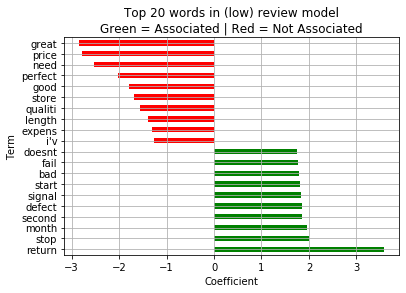

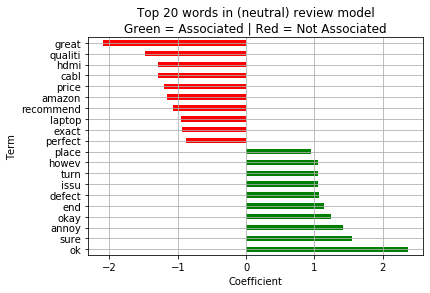

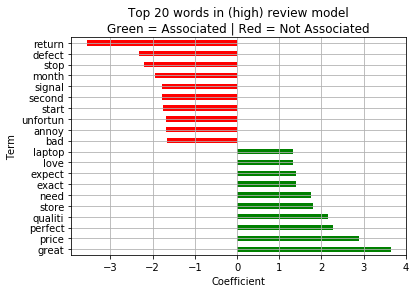

In [36]:
# Plot coefficient 

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    
    df['c'] = df['Coefficient']>0
    
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    
    ax.set_xlabel("Coefficient")

n_terms = 10
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, 
               R=cat[c]), lr_m[c], tfidf_m.get_feature_names(), n_terms)

### Test output
- Below is a test function which allows to supply review to see how well the model will predict it's rating. 
- For simplicity, logistic regression model is used and only allow for one review at a time.
- The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of logistic regression models. 
- Each model has an independent assessment of how likely it is that our review is a positive hit.  

In [37]:
# Function to test review
def test_review(text,model):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=model[m].predict_proba(test_new)[0][1]))       

In [38]:
# Bad review
test_review('Too short and could not connect to TV. It had a bad signal. Disappointed with the purchase. Returned to get the refund',lr_m)

Review text: "Too short and could not connect to TV. It had a bad signal. Disappointed with the purchase. Returned to get the refund"

Model Predction
Model (low): 75.9%
Model (neutral): 9.2%
Model (high): 13.8%


In [39]:
# Good Review
test_review('This is the best cable I received so far. It worked well. I am glad I bought it.',lr_m)

Review text: "This is the best cable I received so far. It worked well. I am glad I bought it."

Model Predction
Model (low): 2.8%
Model (neutral): 3.7%
Model (high): 94.7%


### Save Model

In [40]:
# Need to save 3 models